In [1]:
#Dependencies
import os
import numpy as np
import pylab as pl
import tensorflow as tf
import matplotlib.pyplot as plt

import utils.plotutils as plu
import utils.imreadin as imr
import utils.animutils as aniu

%matplotlib inline

In [15]:
#Model Parameters

tanh_model = 0
relu_model = 0
sigmoid_model = 1

#network params
compression = 31
patchsize = 16
patchlen = 12

#training params
batchsize = 50
iterations = 500
epochs = 3

if(tanh_model):
    noisexsigma = 0
    noisersigma = 0
    minact = 0
    minslo = 0 
    learning_rate = 0.01
    model_type = 'tanh'
elif(relu_model):
    noisexsigma = 0 #0.01
    noisersigma = 0 #0.5
    minact = 0
    minslo = 0 
    learning_rate = 0.1
    model_type = 'relu'
elif(sigmoid_model):
    #noise
    noisexsigma = 0.0
    noisersigma = 0.00
    minact = 0 
    minslo = 0
    learning_rate = 0.01
    model_type = 'sigmoid'
else:
    raise ValueError('No model specified!')

In [16]:
fpath = '../vanHaterenNaturalMovies/vid075'
fps = 25 #approximated from http://redwood.berkeley.edu/bruno/data/vid075/README and increased by me.
nframes = 9600
rawframeh = 128
rawframew = 128
barw = 16
framew = rawframew - barw #in pixels
frameh = rawframeh - barw #in pixels

#convert to degrees
ppd = 6 #pixels per degree subtended on retina (estimated 10deg for 64px in dong atick 95)
framewdeg = framew/ppd 
framehdeg = frameh/ppd
#sampling rate
deltawdeg = 1./ppd
deltahdeg = 1./ppd 
deltathz = 1./fps


In [17]:
def readMov(path, frames, height, width, barwidth, patch_edge_size=None, time_size = None, normalize_patch=False):
    """
    Reads in a movie chunk form the van Hatteren database.

    Parameters
    ----------
    path  :   string indicating filepath to read from 
    frames:   integer number of frames in the movie
    height:   integer height in pixels of each frame
    width:    integer width in pixels of each frame
    barwidth: integer height of black bar artifact in movie 
    patch_edge_size: integer length of patch in pixels
    
    Returns
    -------
    d       : numpy matrix with pixel values for movie.
    
    """
    with open(path, 'rb') as fid:
        #read in movie
        d = np.fromfile(fid, np.dtype('uint8'))

    #put data back into a movie shape
    d = np.reshape(d,(frames,height,width))
    #remove black bar from top, and make the other side even too
    d = d[:,barwidth:,int(barwidth/2):-int(barwidth/2)]
    tr_frames, tr_height, tr_width = np.shape(d)
    #print(np.shape(d))
    
    if (patch_edge_size != None):
        htiles = np.int(np.floor(tr_height/patch_edge_size))
        wtiles = np.int(np.floor(tr_width/patch_edge_size))
        ftiles = np.int(np.floor(tr_frames/time_size))
        #print('height'+str(tr_width)+'patch'+str(patch_edge_size)+'htiles'+str(htiles))
        print(np.shape(d))
        print('making patches...')
        tiled_d = np.asarray(np.split(d[:,:,0:patch_edge_size*wtiles], wtiles,2)) # tile column-wise
        print(np.shape(tiled_d))
        tiled_d = np.asarray(np.split(tiled_d[:,:,0:patch_edge_size*htiles], htiles,2)) #tile row-wise
        print(np.shape(tiled_d))
        tiled_d = np.asarray(np.split(tiled_d[:,:,0:time_size*ftiles], ftiles,2)) #tile time-wise
        print(np.shape(tiled_d))
        tiled_d = np.transpose(np.reshape(np.transpose(tiled_d,(4,5,3,0,1,2)),(patch_edge_size,patch_edge_size,time_size,-1)),(3,0,1,2)) #stack tiles together
        print(np.shape(tiled_d))
        if(normalize_patch):
            print('normalizing patches...')
            tiled_d = tiled_d - np.mean(tiled_d,axis=(1,2,3),keepdims=True)
            tiled_d = tiled_d/np.std(tiled_d,axis=(1,2,3),keepdims=True)
        return(tiled_d)
        
    else:
        return(d)

In [18]:
m = readMov(fpath, nframes, rawframeh, rawframew, barw, patch_edge_size=patchsize, time_size=patchlen, normalize_patch=True)
np.random.shuffle(m)
np.shape(m)

(9600, 112, 112)
making patches...
(7, 9600, 112, 16)
(7, 7, 9600, 16, 16)
(800, 7, 7, 12, 16, 16)
(39200, 16, 16, 12)
normalizing patches...


(39200, 16, 16, 12)

In [19]:
#load in movie
try:
    m
except NameError:
    print("Loading Movie...")
    m = readMov(fpath, nframes, rawframeh, rawframew, barw, patch_edge_size=patchsize, time_size=patchlen, normalize_patch=True)
    np.random.shuffle(m)
    #mm = m - np.mean(m,axis=(1,2)).reshape(-1,1,1)
    
print("Movie Loaded. Shape is "+str(np.shape(m)))

Movie Loaded. Shape is (39200, 16, 16, 12)


In [20]:
#params of clips
imxlen = len(m[0,:,0,0])
imylen = len(m[0,0,:,0])
imflen = len(m[0,0,0,:])
nimages = len(m[:,0,0,0])

nimstrained = batchsize * iterations

if(nimstrained > nimages):
    print('ERROR! Trying to train',nimstrained,'patchess, but we only have',nimages,'patches!')
else:
    print('Training',nimstrained,'out of',nimages,'total patches.')

Training 25000 out of 39200 total patches.


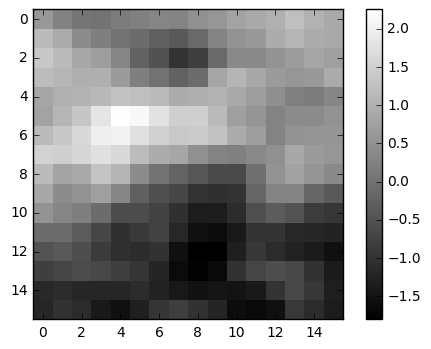

In [21]:
## show an example image
plt.imshow(m[274,:,:,1],cmap='gray',interpolation='none')
plt.colorbar()

In [22]:
nneurons = np.int(imxlen*imylen*imflen/compression)
print('Compressing by',compression,'for a total of',nneurons,'neurons')
savefolder = str('./output/actfun_'+model_type+'/neurons_'+str(nneurons)+'/noise_in_'+str(noisexsigma)+'_out_'+str(noisersigma)+'/')
if not os.path.exists(savefolder):
    os.makedirs(savefolder)

#setup our graph
    
#input image
x = tf.placeholder(tf.float32, shape=(batchsize,imxlen*imylen*imflen),name='input_patch')

#activation function type
act_fun = tf.placeholder(tf.string, name= 'activation_function')

#noise
nxc = noisexsigma**2
nrc = noisersigma**2
nx = tf.constant(nxc,dtype=tf.float32,name='input_noise')
nr = tf.constant(nrc,dtype=tf.float32,name='internal_noise')

#weights
win = tf.Variable(tf.random_normal([imxlen*imylen*imflen,nneurons],dtype=tf.float32,stddev=0.1),name='weights_in')
#wout = tf.Variable(tf.random_normal([nneurons,imxlen*imylen],dtype=tf.float32,stddev=0.01),name='weights_out')

#bias
bias = tf.Variable(tf.random_normal([nneurons],dtype=tf.float32,stddev=0.1),name='bias')

#define nonlinearities
def tanh_fun(arg):
    return tf.nn.tanh(arg) 
def sigmoid_fun(arg):
    return tf.nn.sigmoid(arg) 
def relu_fun(arg):
    return tf.nn.relu(arg) 
def no_fun(arg):
    return arg

#calculate input
linearin = tf.add(tf.matmul(tf.add(x,nx),win),bias)
yin = tf.case({tf.equal(act_fun,'tanh'): (lambda: tanh_fun(linearin)),
               tf.equal(act_fun,'sigmoid'): (lambda: sigmoid_fun(linearin)),
               tf.equal(act_fun,'relu'): (lambda: relu_fun(linearin))},
              default=(lambda: no_fun(linearin)),
              exclusive=True, name = 'input_nonlinearity')

#calculate output
linearout = tf.matmul(yin,tf.transpose(win))
yout = tf.case({tf.equal(act_fun,'tanh'): (lambda: tanh_fun(linearout)),
                tf.equal(act_fun,'sigmoid'): (lambda: sigmoid_fun(linearout)),
                tf.equal(act_fun,'relu'): (lambda: relu_fun(linearout))},
               default=(lambda: no_fun(linearout)),
               exclusive=True, name='output_nonlienarity')

#calculate reconstruction
xp = tf.add(yout,nr)

#calculate cost
cost = tf.sqrt(tf.reduce_mean(tf.square(x-xp)))

train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Compressing by 31 for a total of 99 neurons


In [23]:
#run it!
#sess = tf.Session
with tf.Session() as sess:
    #initialize vars
    init = tf.global_variables_initializer()
    sess.run(init)
    
    #save evolution of system over training
    cost_evolution = []
    wmean_evolution = []
    
    weights_evolution = []
    images = []
    recons = []
    
    #train over niterations
    nits = iterations #full run
    
    print('Training {} iterations in {} epochs...'.format(nits, epochs))
    for epoch in range(epochs):
        print('\nEpoch {}: '.format(epoch+1))
        np.random.shuffle(m)
        for ii in range(nits):
            clip = np.reshape(m[ii*batchsize:(1+ii)*batchsize,:,:,:],(batchsize,-1)).astype(np.float32)
            #print(np.shape(clip))
            sess.run(train_step, feed_dict={x:clip, act_fun:model_type})

            #save evolution of params
            objcost, wmean = sess.run([cost,win], feed_dict={x:clip, act_fun:model_type})
            cost_evolution.append(objcost)
            wmean_evolution.append(np.mean(wmean))
            
            if(ii%(int((nits)/10))==0):
                print(str(ii)+', ',end="")
                #dump our weights
                w = sess.run(win, feed_dict={x:clip, act_fun:model_type})
                weights_evolution.append(np.reshape(w,(imxlen,imylen,imflen,nneurons)))
                #and save our image and reconstruction
                images.append(np.reshape(clip,[batchsize,imxlen,imylen,imflen]))
                recons.append(np.reshape(sess.run(xp, feed_dict={x:clip, act_fun:model_type}),[batchsize,imxlen,imylen,imflen]))
                
    
    final_weights = sess.run(win, feed_dict={x:clip, act_fun:model_type})
    print('\nDone!')

Training 500 iterations in 3 epochs...

Epoch 1: 
0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 
Epoch 2: 
0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 
Epoch 3: 
0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 
Done!


(30, 16, 16, 12, 99)
(99, 16, 16, 12)


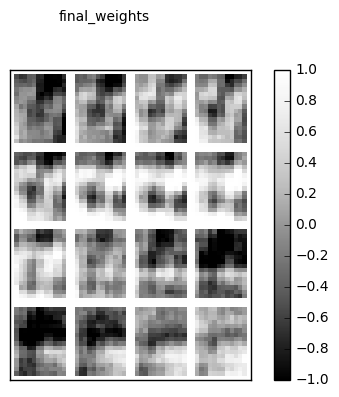

In [26]:
from importlib import reload
reload(plu)
#Show our final weights
#wr = np.rollaxis(np.reshape(final_weights,(imxlen,imylen,nneurons)),2)
#im = plu.display_data_tiled(wr, normalize=False, title="final_weights", prev_fig=None)

#Show our final weights
print(np.shape(weights_evolution))
#print(np.shape(np.reshape(weights_evolution,(len(weights_evolution),imxlen,imylen,imflen,nneurons))))
weights_evolution_r = np.rollaxis(np.array(weights_evolution),4,1)
my_final_weights = weights_evolution_r[-1]
print(my_final_weights.shape)
#print(np.shape(final_weights[1,:,:,:]))
(f,sa,ai) = plu.display_data_tiled(my_final_weights[1,:,:,:], normalize=False, title="final_weights", prev_fig=None)
f.savefig(savefolder+'weights_final.png') 

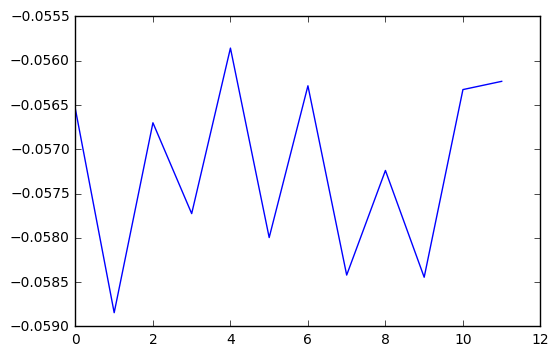

In [32]:
plt.plot(my_final_weights.mean(2).mean(1).mean(0))

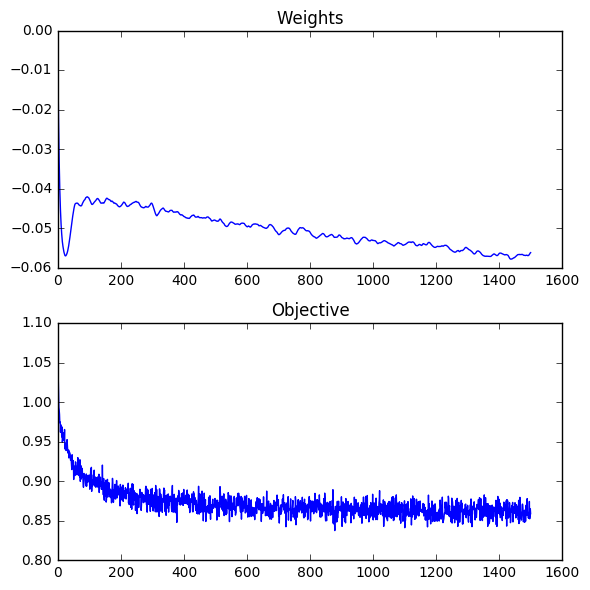

In [25]:
f2 = plt.figure(figsize=(6,6))

plt.subplot(2,1,1,title='Weights')
plt.plot(wmean_evolution)

plt.subplot(2,1,2,title='Objective')
plt.plot(cost_evolution)

plt.tight_layout()

f2.savefig(savefolder+'/cost_weights.png') 

/home/vasha/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


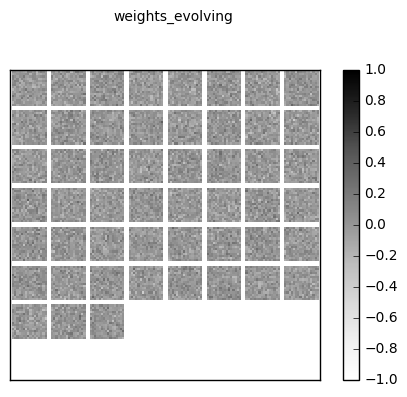

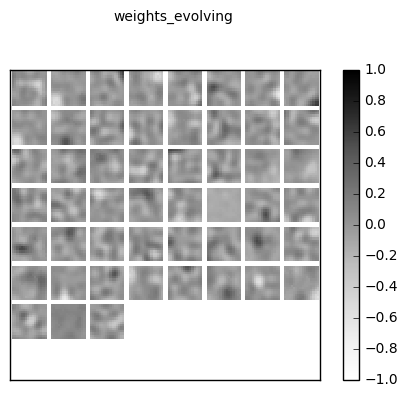

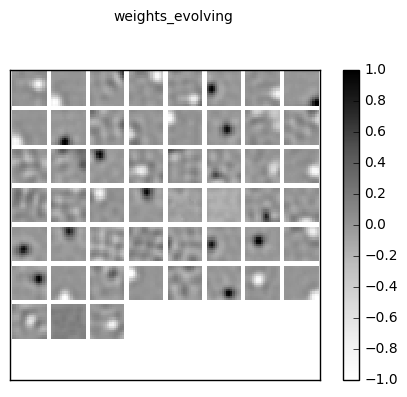

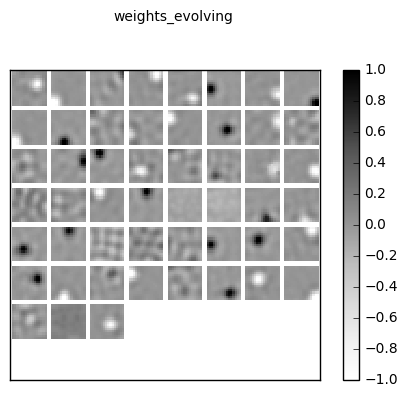

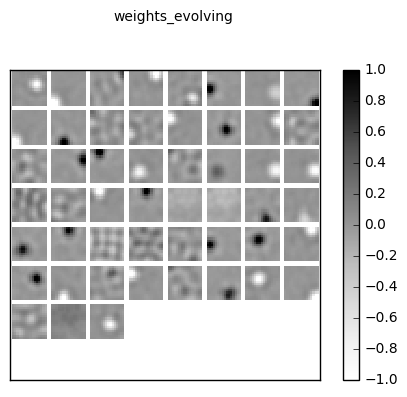

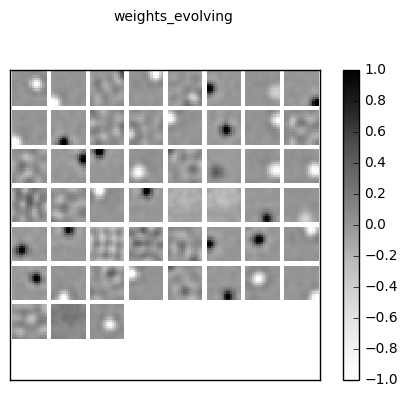

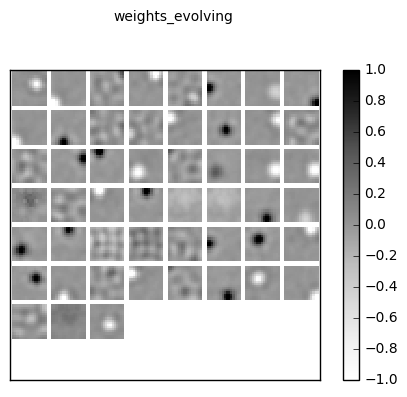

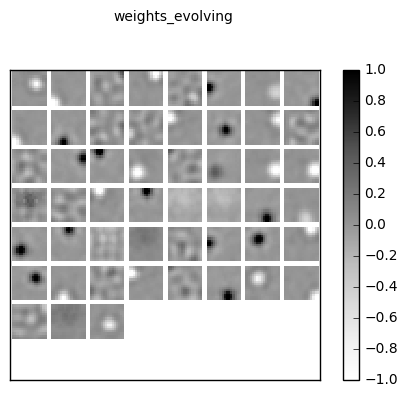

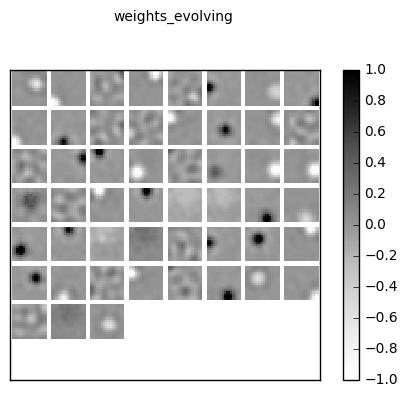

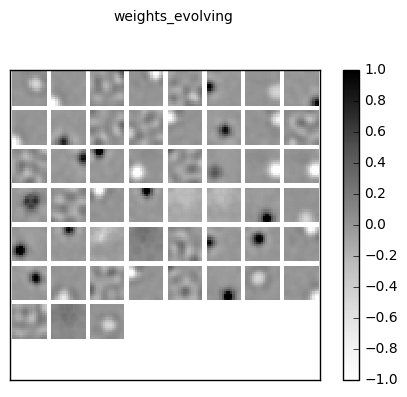

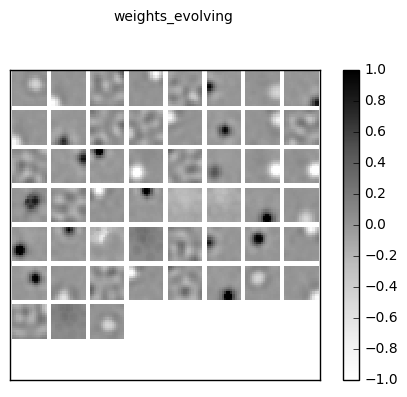

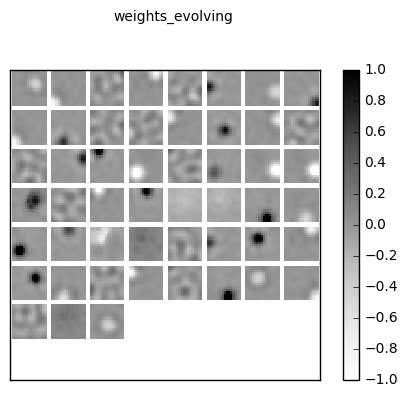

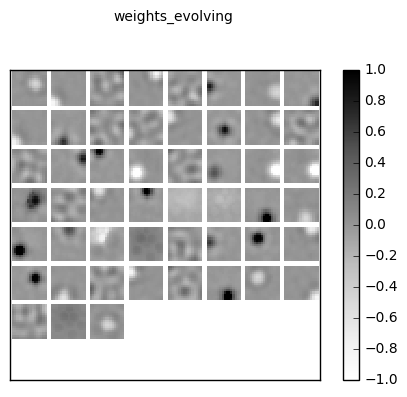

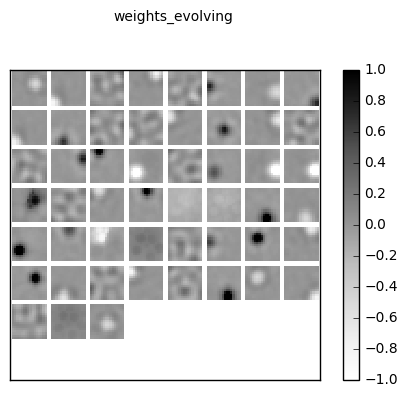

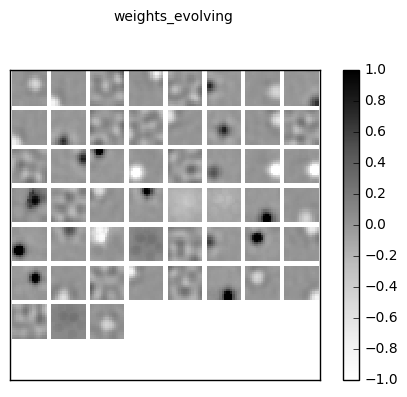

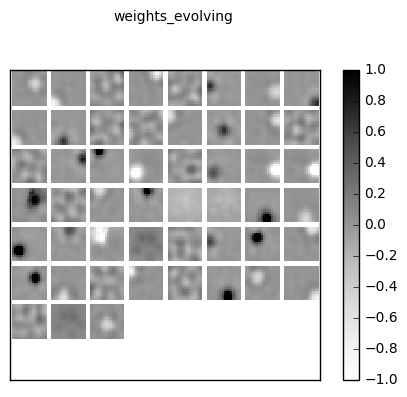

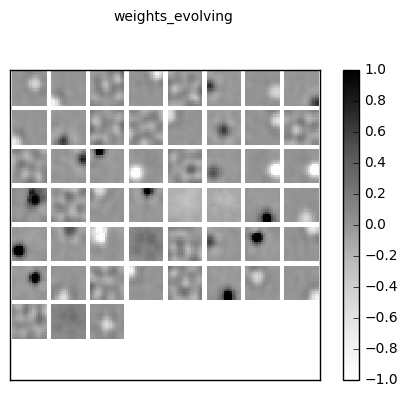

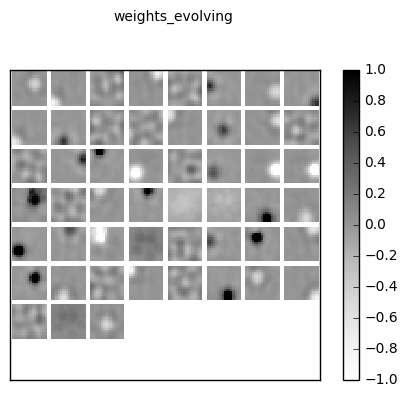

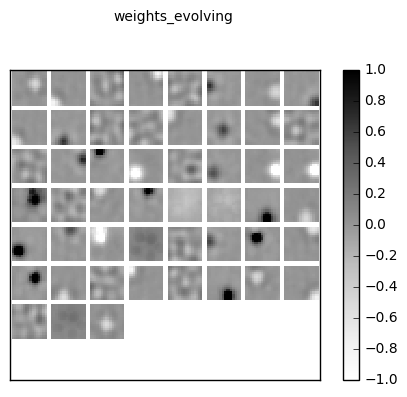

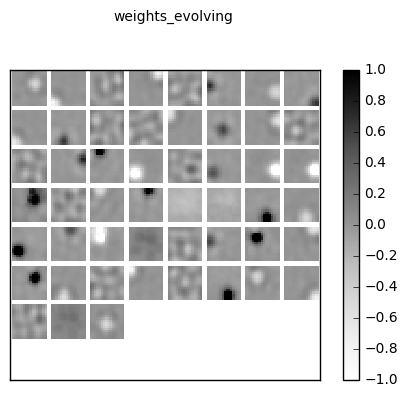

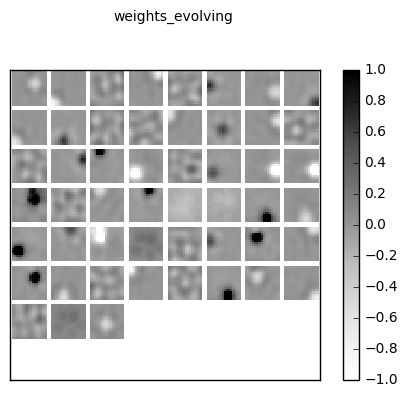

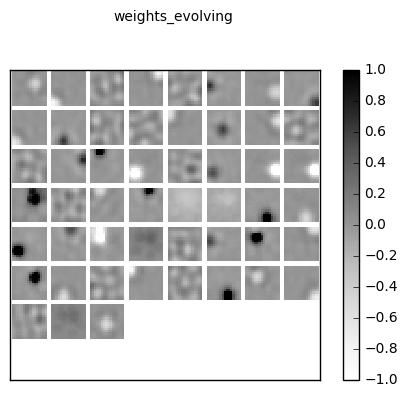

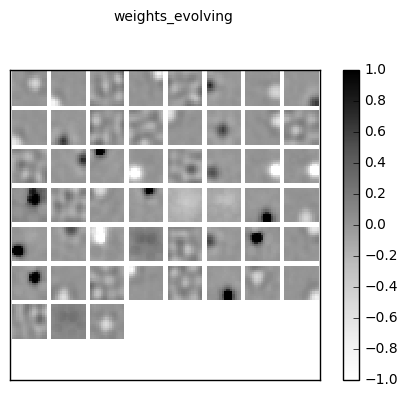

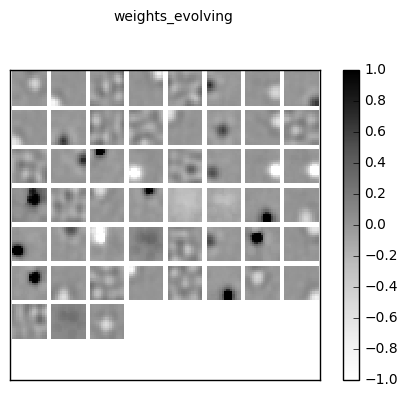

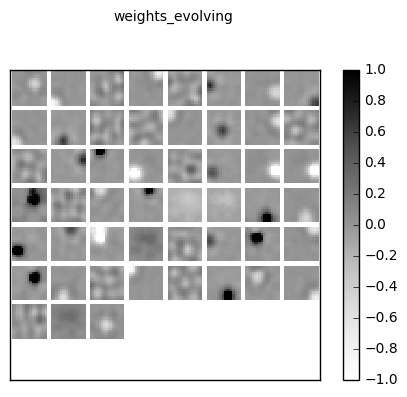

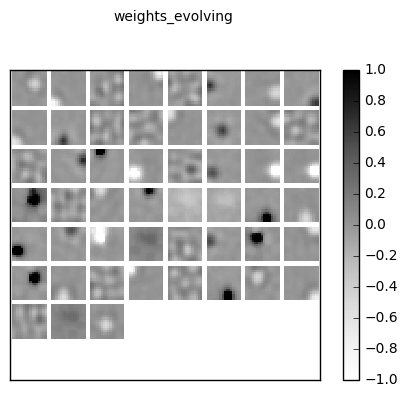

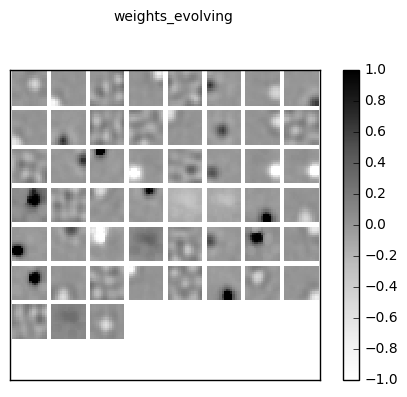

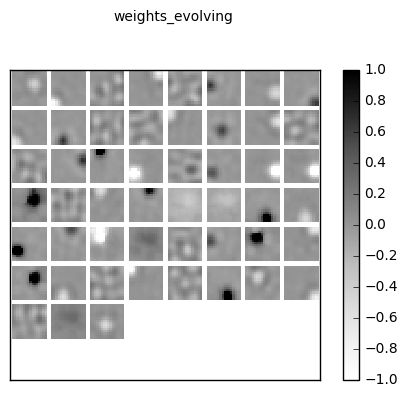

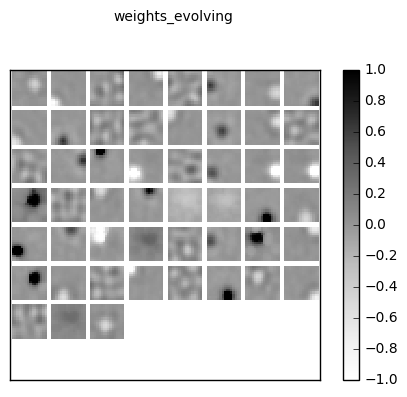

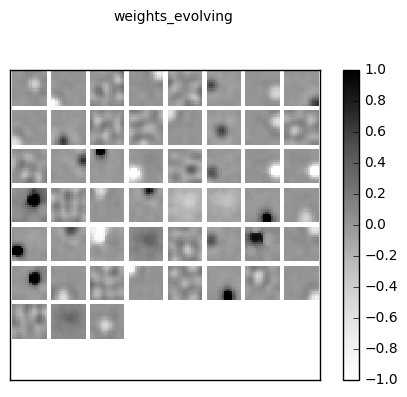

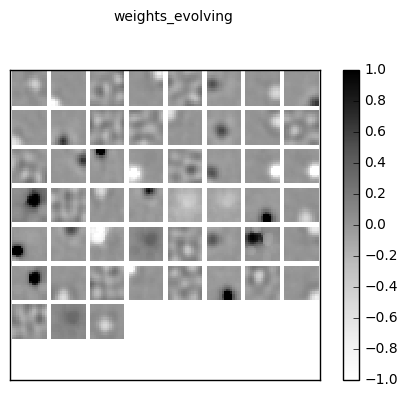

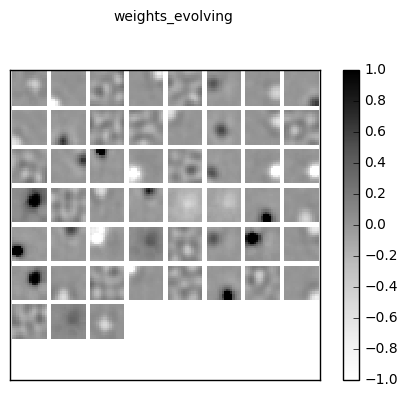

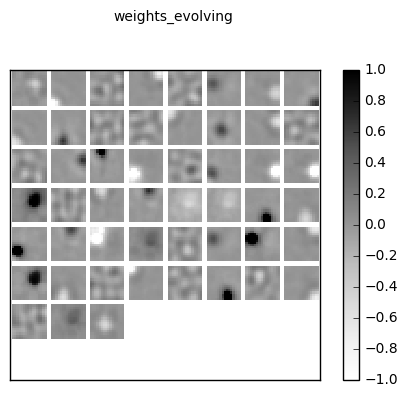

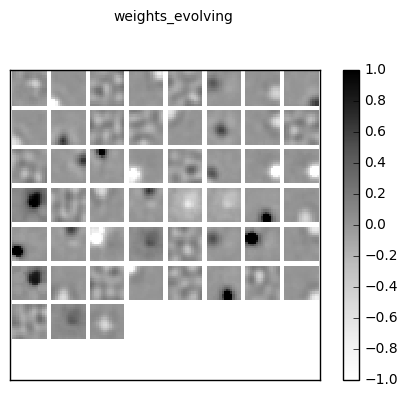

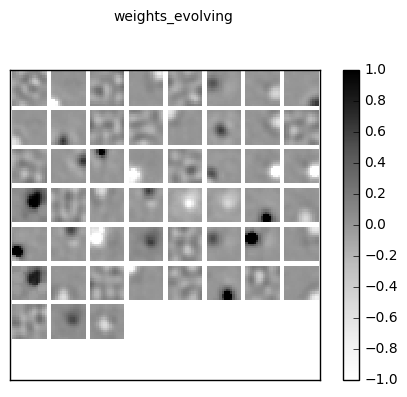

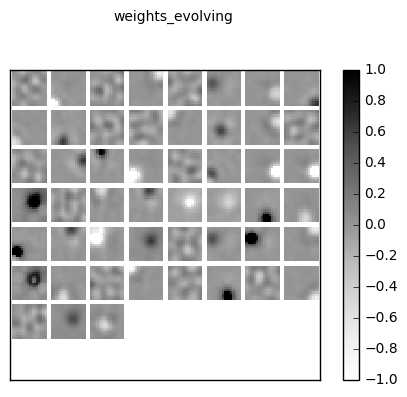

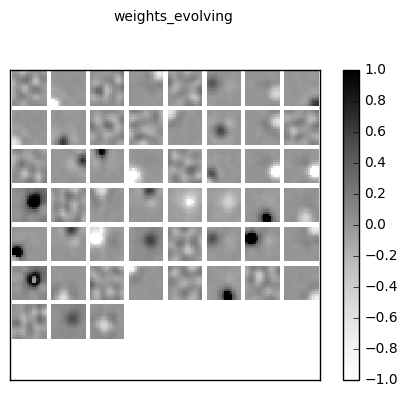

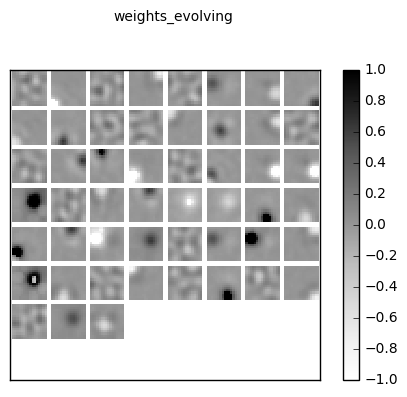

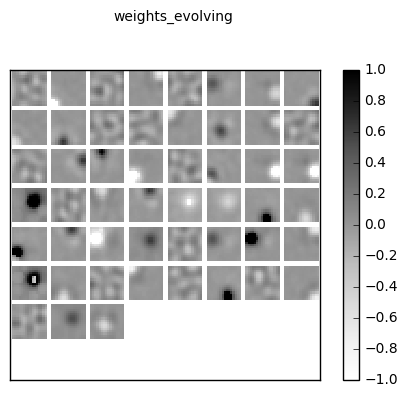

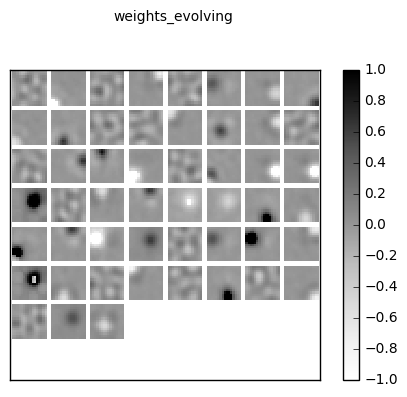

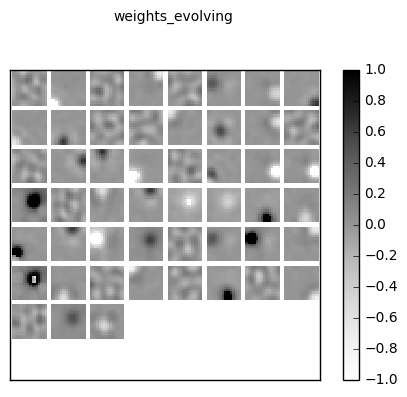

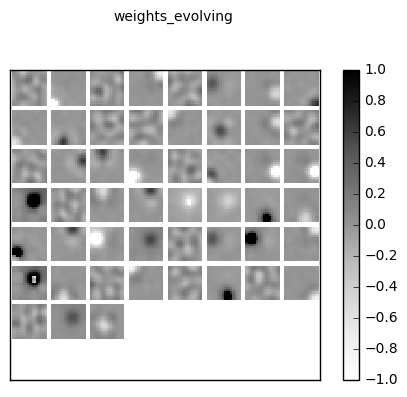

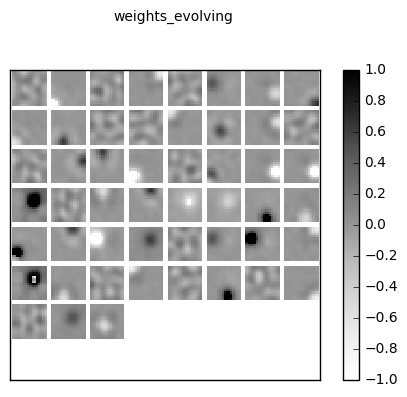

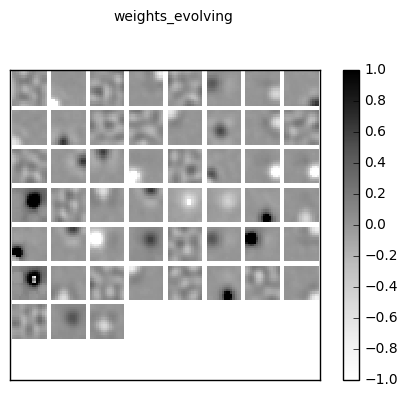

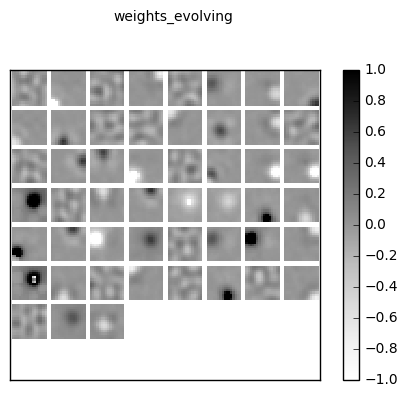

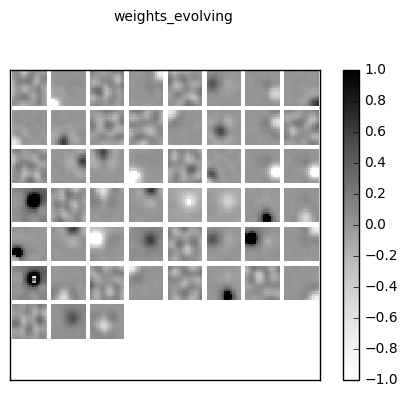

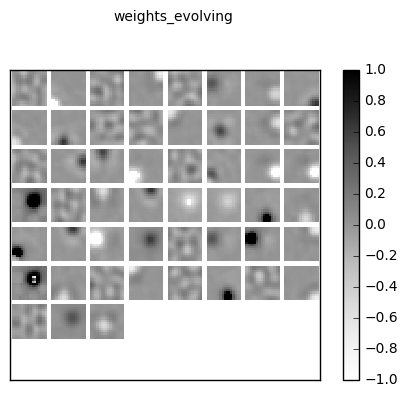

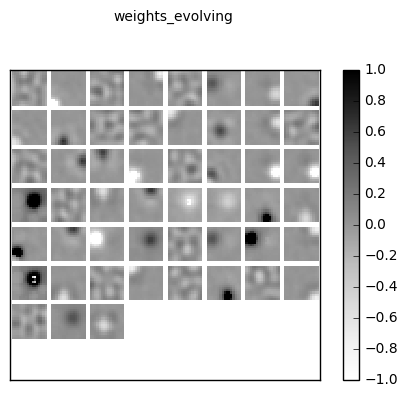

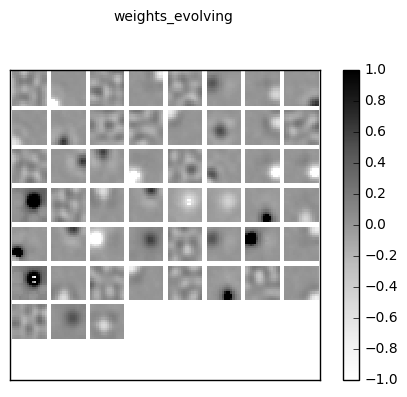

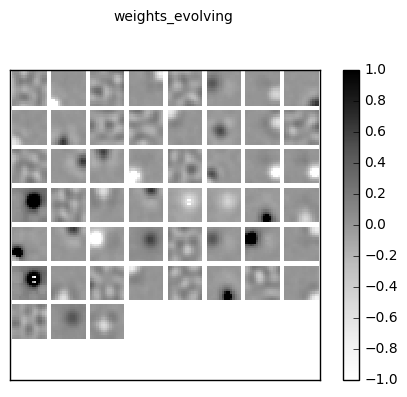

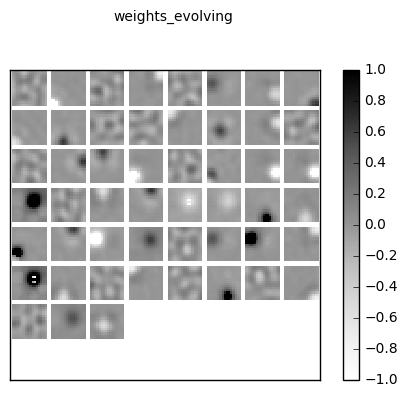

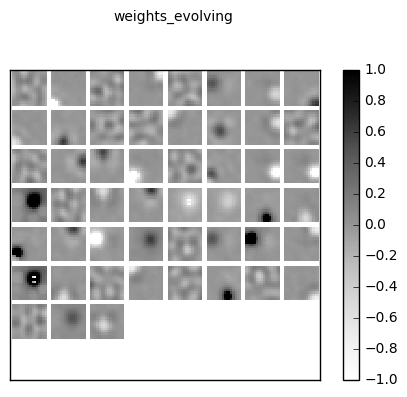

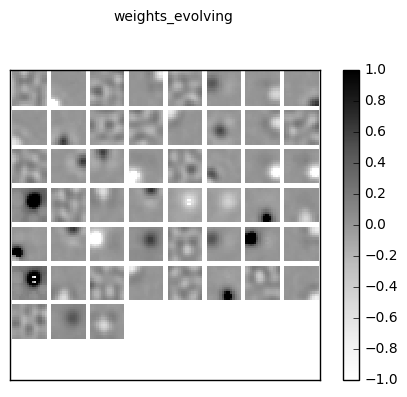

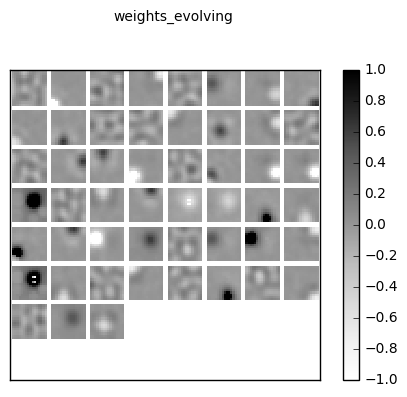

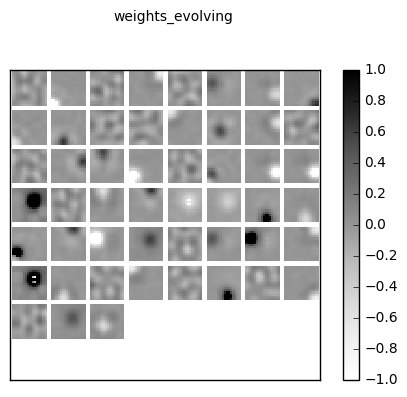

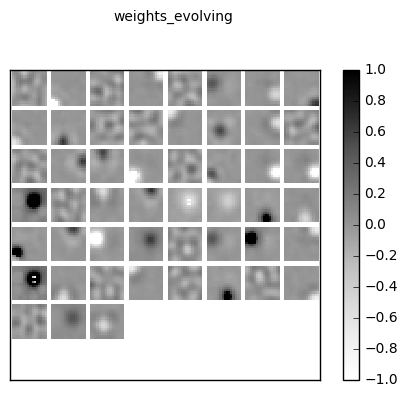

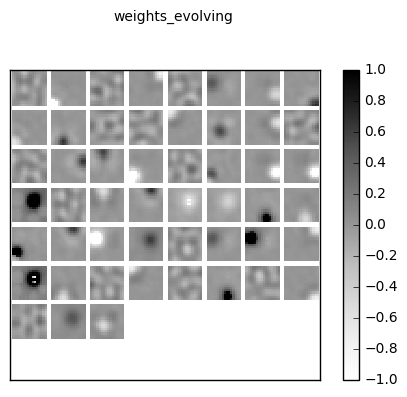

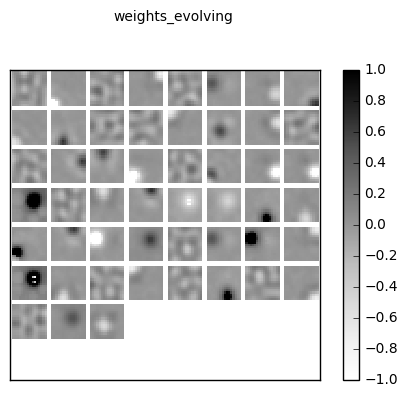

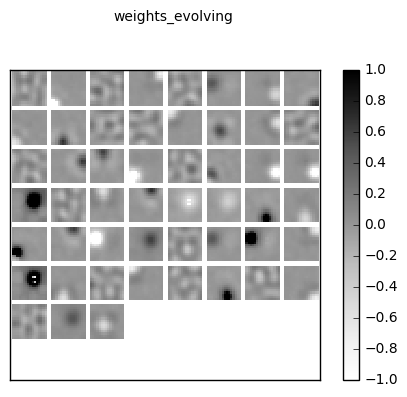

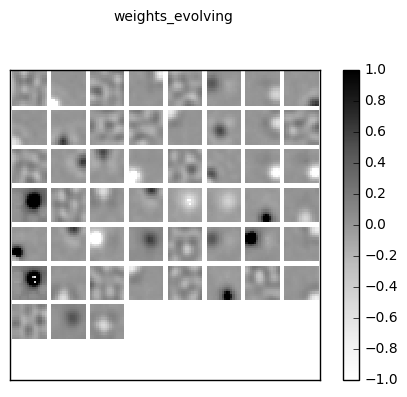

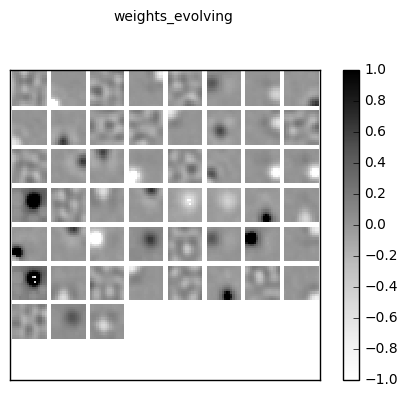

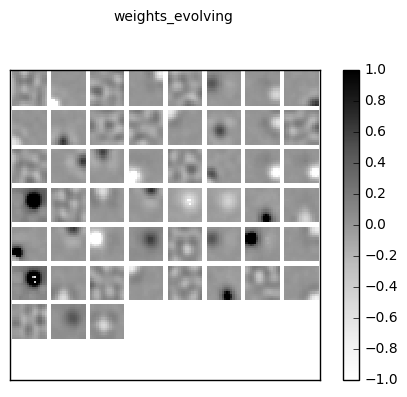

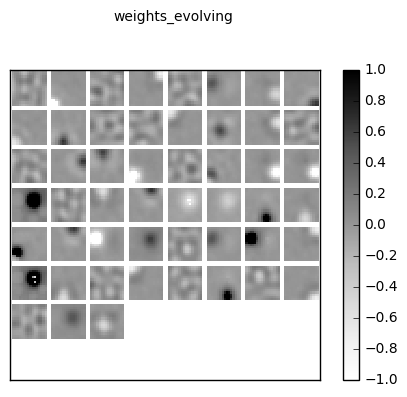

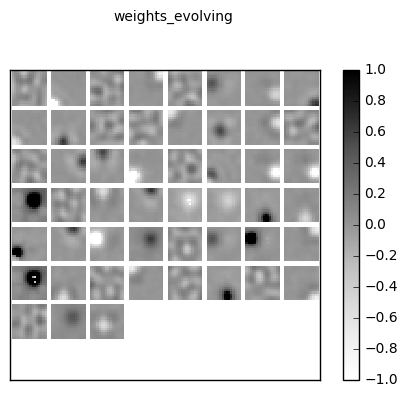

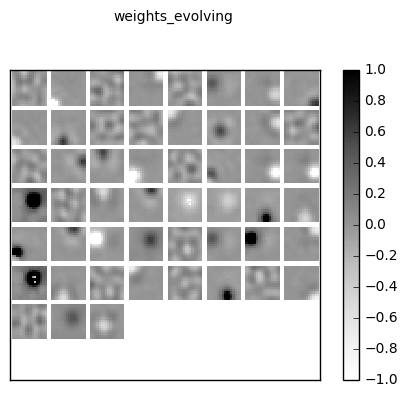

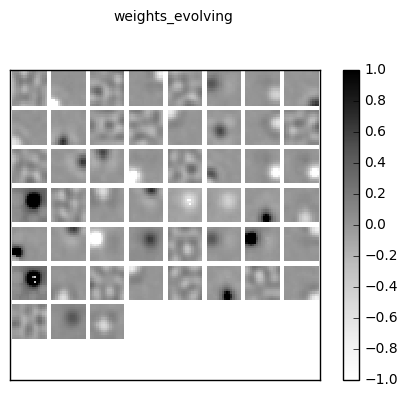

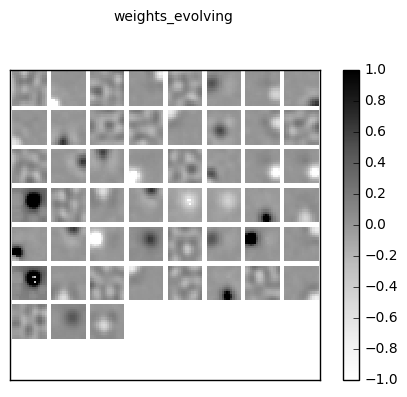

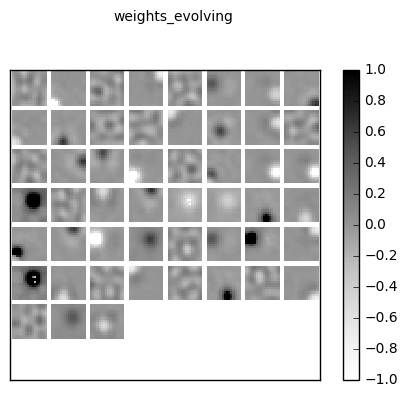

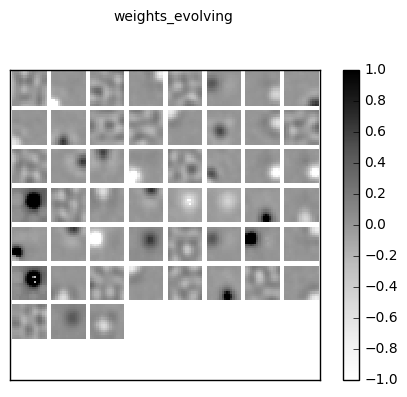

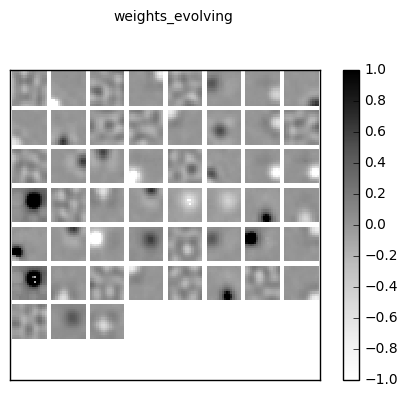

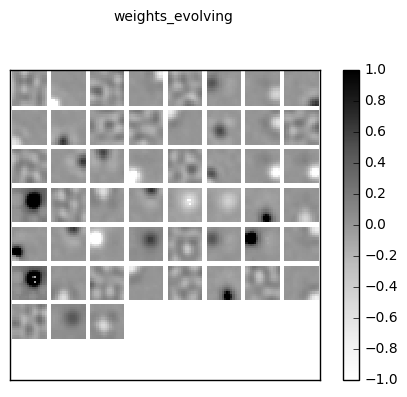

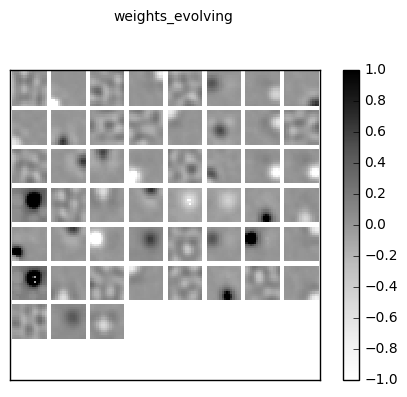

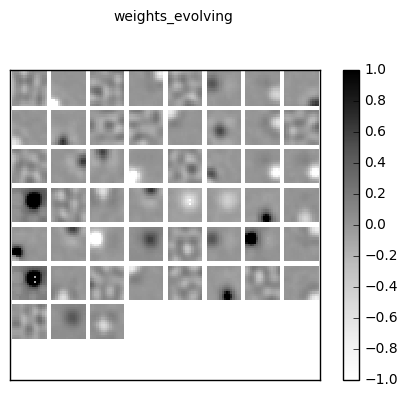

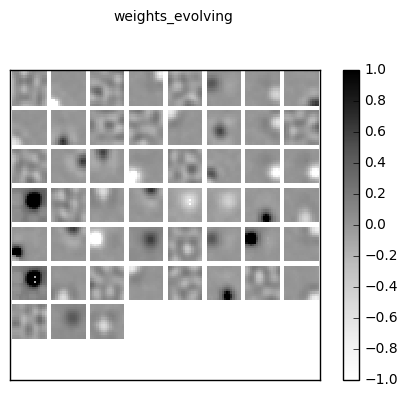

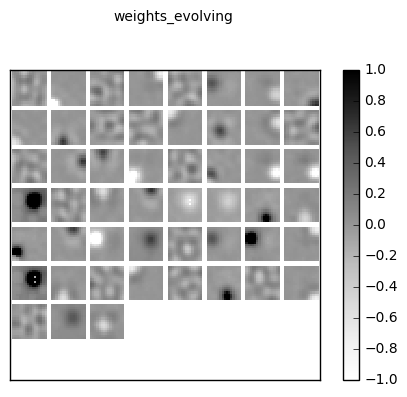

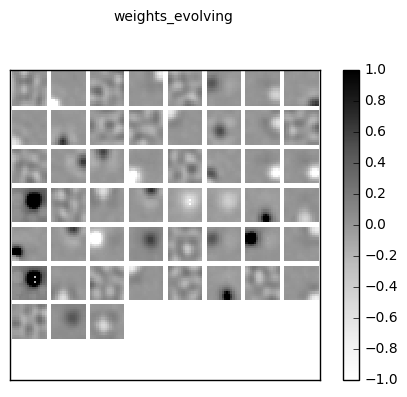

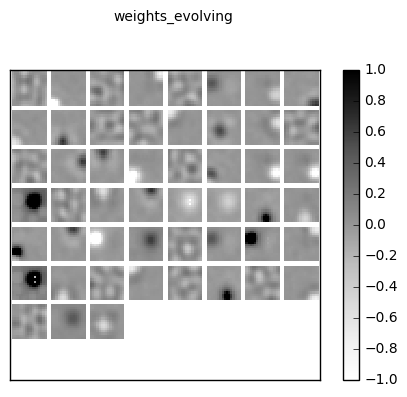

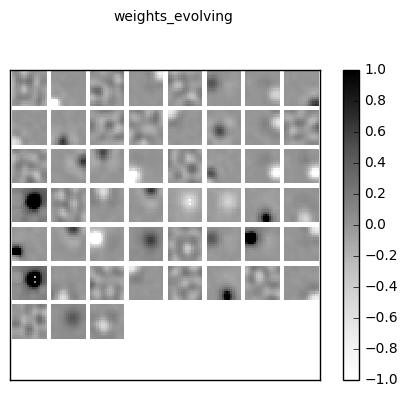

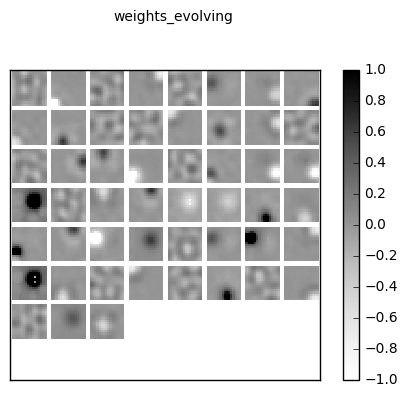

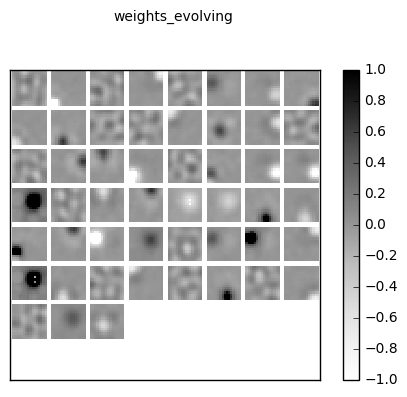

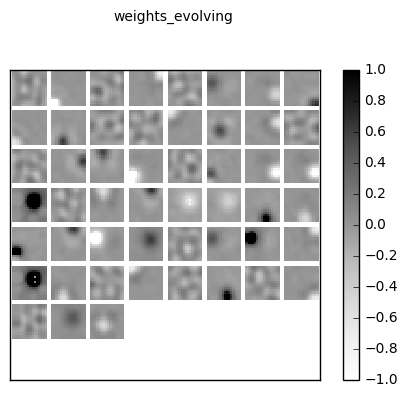

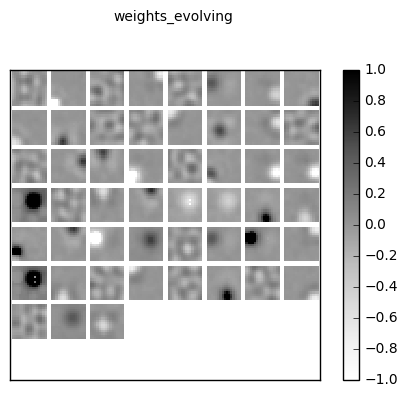

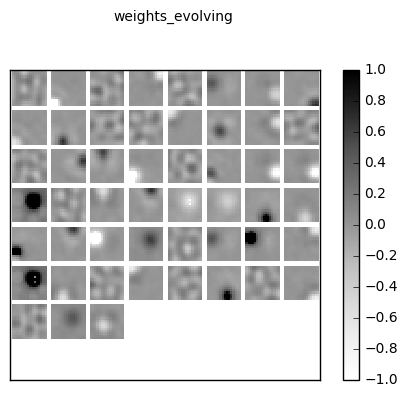

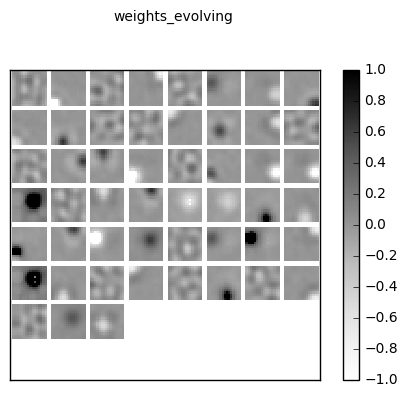

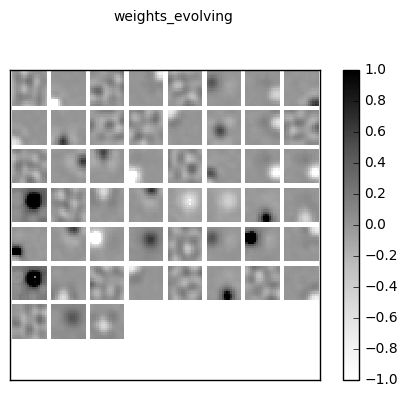

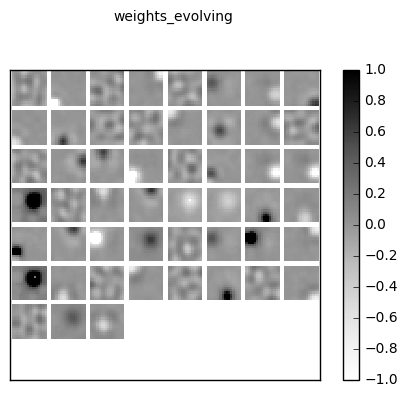

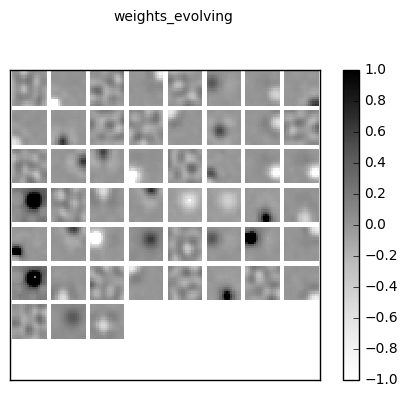

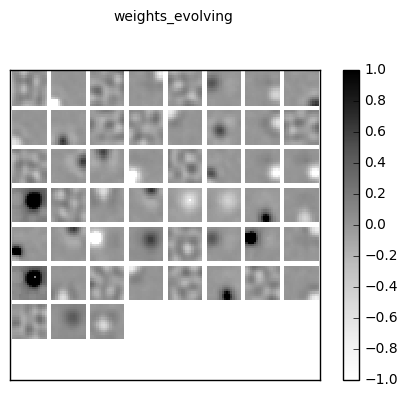

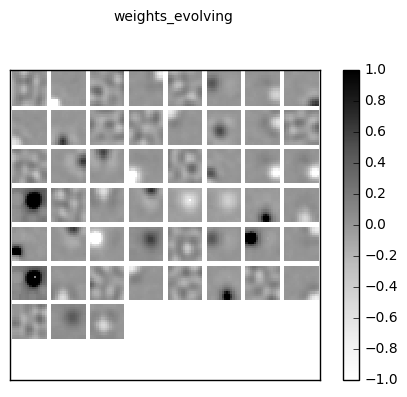

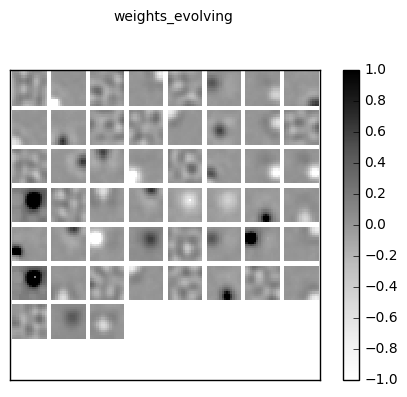

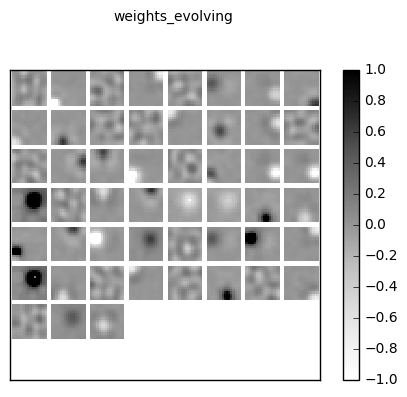

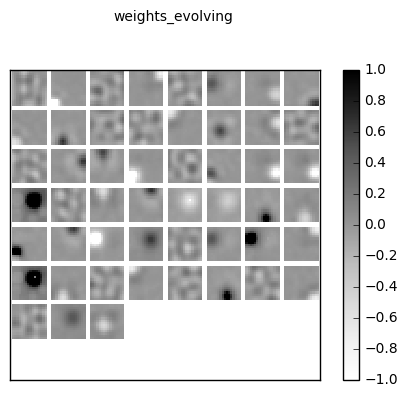

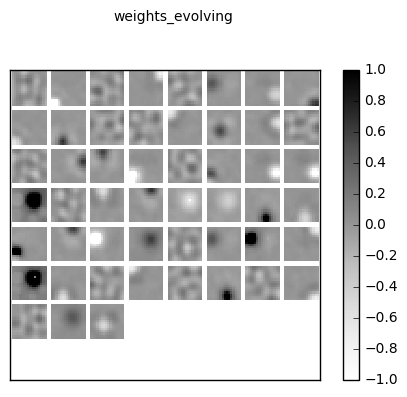

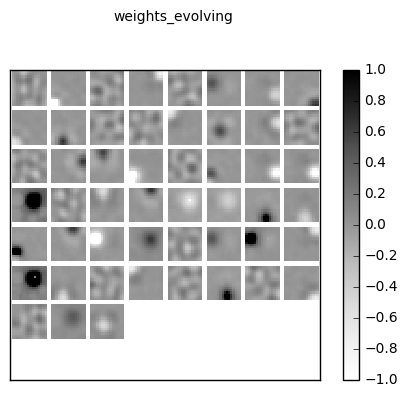

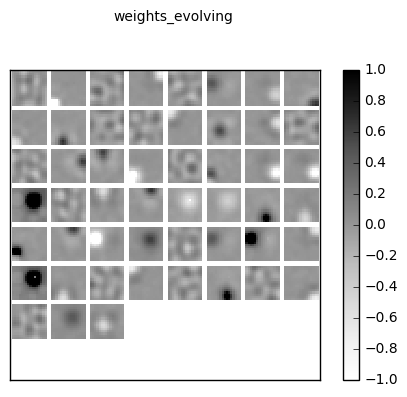

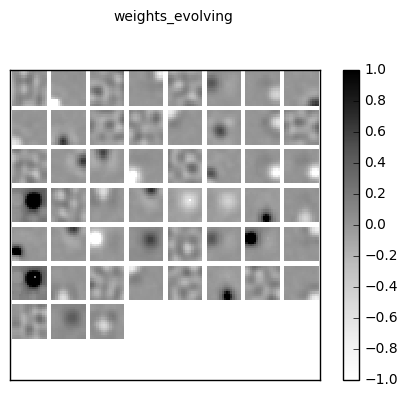

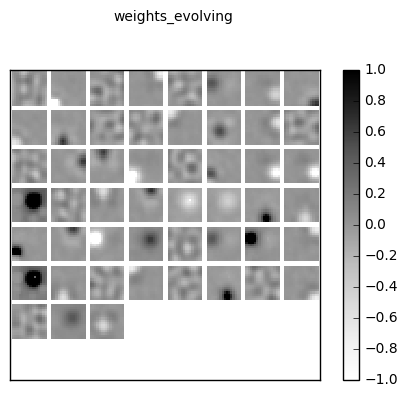

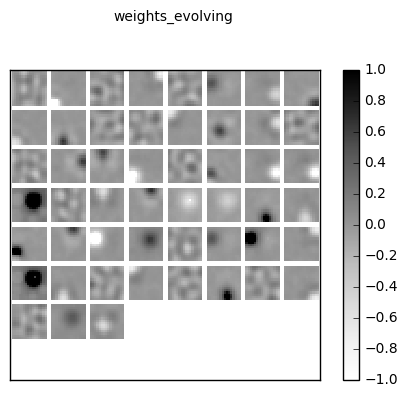

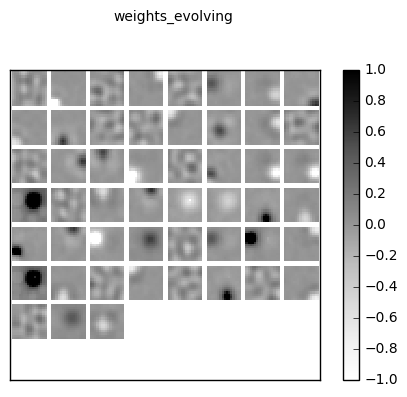

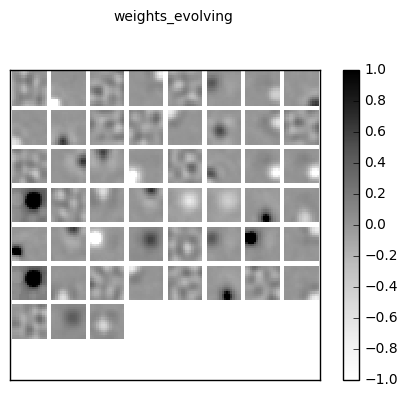

In [27]:
#save figures
for i in range(len(weights_evolution_r)):
    (f,sa,ai) = plu.display_data_tiled(weights_evolution_r[i], normalize=False,title="weights_evolving", prev_fig=None)
    f.savefig(savefolder+'/weights_evolution_'+str(i)+'.png') 

TypeError: Invalid dimensions for image data

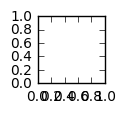

In [220]:
#show an example image and reconstruction from the last iteration of learning
patchnum = 3

plots = 4
for i in range(plots):
    plt.subplot(plots,2,2*i+1)#,title='Patch')
    plt.imshow(images[-1][patchnum+i],cmap='gray',interpolation='none')
    plt.axis('off')
    
    plt.subplot(plots,2,2*i+2)#,title='Recon')
    plt.imshow(recons[-1][patchnum+i],cmap='gray',interpolation='none')
    plt.axis('off')


plt.tight_layout()
plt.savefig(savefolder+'/reconstruction.png') 

code to plot the tiling of on and off RFs - for now opencv isn't working

In [11]:
from sklearn import mixture

def fit_circs(samples):
    gmix = mixture.GaussianMixture(n_components=1, covariance_type='full')
    gmix = gmix.fit(samples)
    return(gmix.reshape(1,-1))

def plotonoff(allws):
    
    allws = weights
    #get on center
    onws = np.mean(allws,axis=0)>0
    onws = allws[:,onws]
    #get off center
    offws = np.mean(allws,axis=0)<0
    offws = allws[:,offws]
    #keep track of the circles
    oncircs = []
    offcircs = []

    #blank 16x16 to draw circles
    onrfs = np.zeros_like(weights[0])
    offrfs = np.zeros_like(weights[0])

    #on cells

    for on in onws:
        #circs = cv2.HoughCircles(on,cv2.CV_HOUGH_GRADIENT)
        #circs = cv2.HoughCircles(on, oncircs, cv2.CV_HOUGH_GRADIENT,
                           #dp=1.5, minDist=30, minRadius=3, maxRadius=10)
        #cv2.circle(onrfs,((circ[0,0],i[0,1]),i[0,2],(0,255,0),2))
        oncircs.append(fit_circs(on))

    #off cells
    for off in offws:
        #circs = cv2.HoughCircles(off, offcircs, cv2.CV_HOUGH_GRADIENT,
        #                   dp=1.5, minDist=30, minRadius=3, maxRadius=10)
        #cv2.circle(offrfs,((circ[0,0],i[0,1]),i[0,2],(0,255,0),2))
        offcircs.append(fit_circs(off))

    print(oncircs[0])
        
    #plot
    plt.figure(figsize=(6,6))

    plt.subplot(1,2,1,title='On')
    #for onc in oncircs:
    #    plt.contour(np.linspace(0,,onrfs[1],onc)
        
    plt.subplot(1,2,2,title='Off')
    #plt.imshow(offrfs)

    plt.tight_layout()
    

In [12]:
plotonoff(weights)

NameError: name 'weights' is not defined

In [ ]:
print(weights[1])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

## Autoencoder Math

